<a href="https://colab.research.google.com/github/lakatosgabor/ogyei_dataset_info/blob/main/embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch

In [89]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt

from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image

import seaborn as sns

In [ ]:
# HuBERT modell és tokenizáló betöltése
model_name = "SZTAKI-HLT/hubert-base-cc"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [4]:
# Koszinus távolság számítása
def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    distance = 1 - similarity
    return distance

In [88]:
# Szövegek, amelyeket be akarunk ágyazni
texts = ["Kutyák a parkban", "Kutyák játszanak", "Macskák a fűben", "Hűtőszekrény a konyhában",]

# Szövegek beágyazása
text_embeddings = []
for text in texts:
    # Tokenizálás és modellezés
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=False)
    with torch.no_grad():
        outputs = model(**inputs)
    # Az utolsó réteg kimenetét használjuk vektorokként
    vector = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    text_embeddings.append(vector)

# Koszinus távolságok számítása és normalizálása
text_distances = []
text_pairs = []

for i, vec1 in enumerate(text_embeddings):
    for j, vec2 in enumerate(text_embeddings):
        distance = cosine_distance(vec1, vec2)
        text_distances.append(distance)
        text_pairs.append((texts[i], texts[j]))


# Normalizálás
text_normalized_distances = (text_distances - np.min(text_distances)) / (np.max(text_distances) - np.min(text_distances))

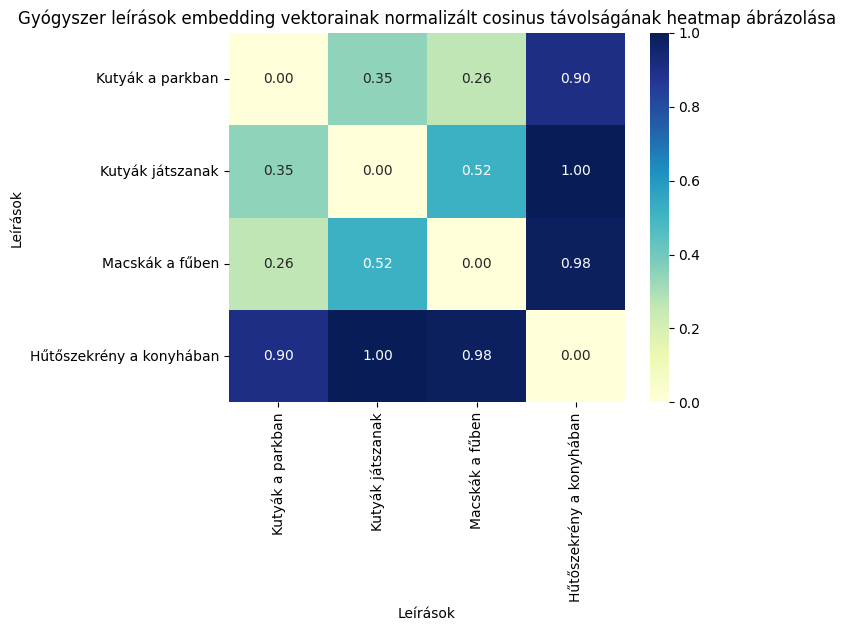

In [90]:
data = text_normalized_distances.reshape(4,4)

# Heatmap létrehozása seaborn segítségével
sns.heatmap(data, annot=True, cmap='YlGnBu', fmt='.2f', xticklabels=texts, yticklabels=texts)

# Tengelycímkék beállítása
plt.xlabel('Leírások')
plt.ylabel('Leírások')
plt.title('Gyógyszer leírások embedding vektorainak normalizált cosinus távolságának heatmap ábrázolása')

# Diagram megjelenítése
plt.show()

In [ ]:
# ViT modell és tokenizáló betöltése képekhez
image_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
image_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [86]:
image_paths = ["/content/kutya.jpg", "/content/kutyajatszik.jpg", "/content/macska.jpg", "/content/huto.jpg"]  # Az elérési utak a képekhez
image_embeddings = []
for path in image_paths:
    image = Image.open(path)
    inputs = image_feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = image_model(**inputs)
    # Az utolsó rejtett állapotokat használjuk vektorokként
    vector = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    image_embeddings.append(vector)

# Koszinus távolságok számítása és normalizálása
image_distances = []
image_pairs = []
for i, img_vec1 in enumerate(image_embeddings):
    for j, img_vec2 in enumerate(image_embeddings):
        distance = cosine_distance(img_vec1, img_vec2)
        image_distances.append(distance)
        image_pairs.append((image_paths[i], image_paths[j]))

# Normalizálás
image_normalized_distances = (image_distances - np.min(image_distances)) / (np.max(image_distances) - np.min(image_distances))


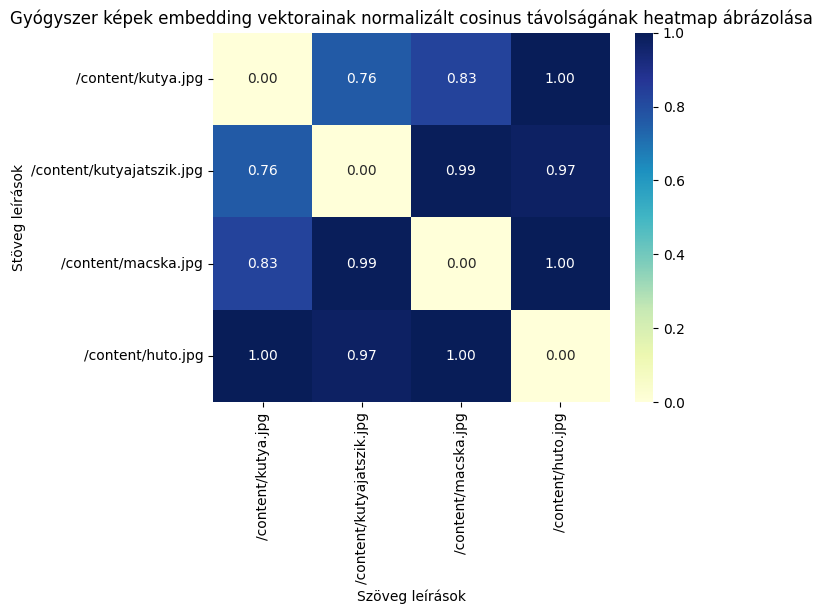

In [91]:
data = image_normalized_distances.reshape(4,4)

# Heatmap létrehozása seaborn segítségével
sns.heatmap(data, annot=True, cmap='YlGnBu', fmt='.2f', xticklabels=image_paths, yticklabels=image_paths)

# Tengelycímkék beállítása
plt.xlabel('Szöveg leírások')
plt.ylabel('Stöveg leírások')
plt.title('Gyógyszer képek embedding vektorainak normalizált cosinus távolságának heatmap ábrázolása')

# Diagram megjelenítése
plt.show()

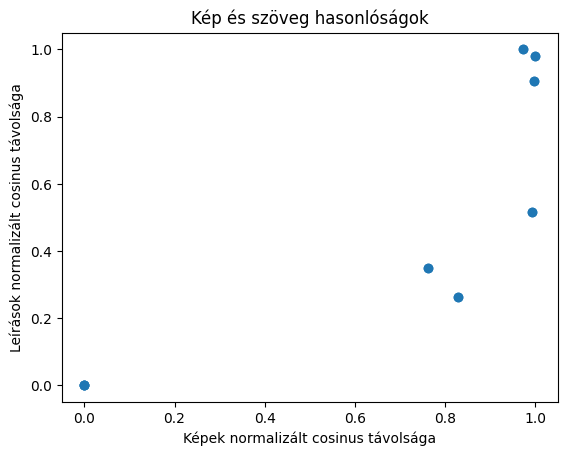

In [92]:
# Pontok ábrázolása
plt.scatter(image_normalized_distances, text_normalized_distances)

# Az x és y tengelyek címkézése
plt.xlabel('Képek normalizált cosinus távolsága')
plt.ylabel('Leírások normalizált cosinus távolsága')
plt.title('Kép és szöveg hasonlóságok')

# Diagram megjelenítése
plt.show()
